Backpropagation Implementation on Hill-Valley Dataset:

In [1]:
using MLDataUtils, CSV, DataFrames, CategoricalArrays, Random
using IterTools, Statistics, StatsBase, Flux

In [2]:
#Preprocessing the Data
hv_train = DataFrame(CSV.File("Hill_Valley_without_noise_Training.data"))
hv_test = DataFrame(CSV.File("Hill_Valley_without_noise_Testing.data"))
hv_data = vcat(hv_train, hv_test)
hv_x = hv_data[!, Not(:class)]
hv_y = hv_data[!, :class]
hv_x = Array{Float64}(hv_x)
hv_x = zscore(hv_x)
hv_data2 = DataFrame(hcat(hv_x, hv_y), :auto)
trainingData, testData = splitobs(hv_data2; at = 0.7)
trainX, trainY, testX, testY = trainingData[!, Not(:x101)], trainingData[!,:x101], testData[!, Not(:x101)], testData[!, :x101]

trainX = Matrix{Float32}(trainX)
testX  = Matrix{Float32}(testX)

364×100 Matrix{Float32}:
 -0.329232   -0.329231   -0.329231   …  -0.329211   -0.329215   -0.329218
 -0.390431   -0.390682   -0.390986      -0.389237   -0.389237   -0.389237
 -0.418064   -0.418064   -0.418064      -0.418063   -0.418063   -0.418063
 -0.395355   -0.395355   -0.395355      -0.395036   -0.3951     -0.39515
 -0.420407   -0.420407   -0.420407      -0.420407   -0.420407   -0.420407
 -0.388202   -0.388202   -0.388202   …  -0.388202   -0.388202   -0.388202
 -0.408343   -0.408343   -0.408343      -0.408343   -0.408343   -0.408343
 -0.413298   -0.413298   -0.413298      -0.413114   -0.413141   -0.413165
 -0.415485   -0.415484   -0.415484      -0.415485   -0.415485   -0.415485
 -0.415752   -0.415752   -0.415752      -0.415783   -0.415776   -0.41577
 -0.410782   -0.410782   -0.410782   …  -0.410782   -0.410782   -0.410782
 -0.411737   -0.411737   -0.411737      -0.411593   -0.411626   -0.411652
  0.940997    0.945801    0.951571       0.917101    0.917101    0.917101
  ⋮            

In [3]:
trainData = []
for i in range(start=1, stop=size(trainX, 1), step=1)
    push!(trainData, (trainX[i, :], [trainY[i]]))
end
testData = []
for i in range(start=1, stop=size(testX, 1), step=1)
    push!(testData, (testX[i, :], [testY[i]]))
end

In [4]:
#Confusion Matrix function
function getConfusionMatrix(model, data)
    VALLEY, HILL = 0, 1
    tPos, tNeg, fPos, fNeg = 0, 0, 0, 0
    for i in 1:size(data, 1)
        if model(data[i][1])[1] >= 0.5 && data[i][2][1] == HILL
            tPos += 1
        elseif model(data[i][1])[1] >= 0.5 && data[i][2][1] == VALLEY
            tNeg += 1
        elseif model(data[i][1])[1] < 0.5 && data[i][2][1] == HILL
            fPos += 1
        else
            fNeg += 1
        end
    end
    return [tPos tNeg ; fPos fNeg]
    end

getConfusionMatrix (generic function with 1 method)

In [5]:
#Backpropagation Implementation using ADAM optimizer
train_conf_matrices = []
test_conf_matrices = []
train_accuracies = [0.0 for i in 1:30]
test_accuracies = [0.0 for i in 1:30]
weight_updates = [0.0 for i in 1:30]
models = []
parameters = []
for i in 1:10
println("Training model " * string(i))
model = Chain(Dense(100, 200, σ), Dense(200, 1, σ))
loss(x, y) = Flux.mse(model(x), y)
optimizer = ADAM()
p = Flux.params(model)
push!(models, model)
push!(parameters, p)          #Saving initial weights for ES Implementation
training_loss = Float32[]
testing_loss = Float32[]
epochs = Int64[]
numParams = size(p[1], 1)*size(p[1], 2) + size(p[2], 1)*size(p[2], 2) + size(p[3], 1)*size(p[3], 2) + size(p[4], 1)*size(p[4], 2)
local num_wt_updates = 0
for epoch in 1:300
    Flux.train!(loss, Flux.params(model), trainData, optimizer)
    num_wt_updates += numParams
    if epoch % 10 == 0
        push!(epochs, epoch)
        push!(training_loss, sum(loss(Array(transpose(trainX)), Array(transpose(trainY)))))
        push!(testing_loss, sum(loss(Array(transpose(testX)), Array(transpose(testY)))))
        train_confusion_matrix = getConfusionMatrix(model, trainData)
        test_confusion_matrix = getConfusionMatrix(model, testData)
        train_accuracy = (train_confusion_matrix[1, 1] + train_confusion_matrix[2, 2]) / (train_confusion_matrix[1, 1] + train_confusion_matrix[2, 2] + train_confusion_matrix[1, 2] + train_confusion_matrix[2, 1])
        test_accuracy = (test_confusion_matrix[1, 1] + test_confusion_matrix[2, 2]) / (test_confusion_matrix[1, 1] + test_confusion_matrix[2, 2] + test_confusion_matrix[1, 2] + test_confusion_matrix[2, 1])
        if train_accuracies[Integer(epoch/10)] == 0
            train_accuracies[Integer(epoch/10)] = train_accuracy
        else
            train_accuracies[Integer(epoch/10)] = (train_accuracies[Integer(epoch/10)] + train_accuracy) / 2
        end
        if test_accuracies[Integer(epoch/10)] == 0
            test_accuracies[Integer(epoch/10)] = test_accuracy
        else
            test_accuracies[Integer(epoch/10)] = (test_accuracies[Integer(epoch/10)] + test_accuracy) / 2
        end
        weight_updates[Integer(epoch/10)] = log(num_wt_updates)
    end
end

train_confusion_matrix = getConfusionMatrix(model, trainData)
test_confusion_matrix = getConfusionMatrix(model, testData)

#train_accuracy = (train_confusion_matrix[1, 1] + train_confusion_matrix[2, 2]) / (train_confusion_matrix[1, 1] + train_confusion_matrix[2, 2] + train_confusion_matrix[1, 2] + train_confusion_matrix[2, 1])

#test_accuracy = (test_confusion_matrix[1, 1] + test_confusion_matrix[2, 2]) / (test_confusion_matrix[1, 1] + test_confusion_matrix[2, 2] + test_confusion_matrix[1, 2] + test_confusion_matrix[2, 1])

push!(train_conf_matrices, train_confusion_matrix)
push!(test_conf_matrices, test_confusion_matrix)
#push!(train_accuracies, train_accuracy)
#push!(test_accuracies, test_accuracy)

end

Training model 1
Training model 2
Training model 3
Training model 4
Training model 5
Training model 6
Training model 7
Training model 8
Training model 9
Training model 10


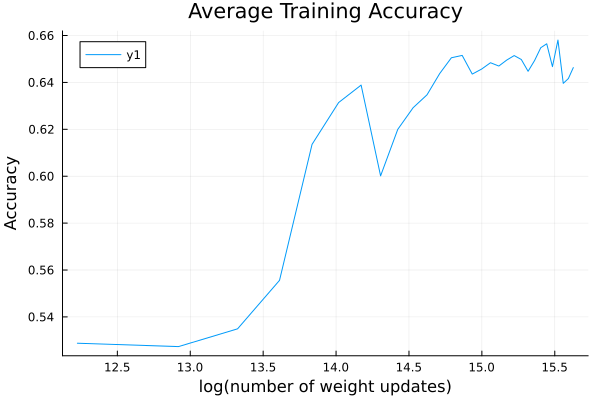

In [6]:
#Plotting Training Accuracy curve
using Plots
plot(weight_updates, train_accuracies, title="Average Training Accuracy")
xlabel!("log(number of weight updates)")
ylabel!("Accuracy")

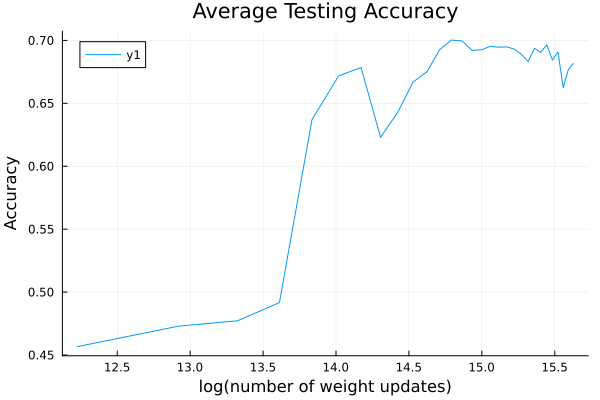

In [7]:
#Plotting Testing Accuracy Curve
plot(weight_updates, test_accuracies, title="Average Testing Accuracy")
xlabel!("log(number of weight updates)")
ylabel!("Accuracy")

In [8]:
#Generating Average Training Confusion Matrix
train_conf_matrix = train_conf_matrices[1]
for i in range(start=2, stop=size(train_conf_matrices, 1), step=1)
    train_conf_matrix[1, 1] = floor((train_conf_matrix[1, 1] + train_conf_matrices[i][1, 1]) / 2)
    train_conf_matrix[1, 2] = floor((train_conf_matrix[1, 2] + train_conf_matrices[i][1, 2]) / 2)
    train_conf_matrix[2, 1] = floor((train_conf_matrix[2, 1] + train_conf_matrices[i][2, 1]) / 2)
    train_conf_matrix[2, 2] = floor((train_conf_matrix[2, 2] + train_conf_matrices[i][2, 2]) / 2)
end
println("Average Training Confusion Matrix")
println("\tP\t\tN")
println("T\t" * string(train_conf_matrix[1, 1]) * "\t\t" * string(train_conf_matrix[1, 2]))
println("F\t" * string(train_conf_matrix[2, 1]) * "\t\t" * string(train_conf_matrix[2, 2]))

Average Training Confusion Matrix
	P		N
T	403		293
F	6		144


In [9]:
#Generating Average Testing Confusion Matrix
test_conf_matrix = test_conf_matrices[1]
for i in range(start=2, stop=size(test_conf_matrices, 1), step=1)
    test_conf_matrix[1, 1] = floor((test_conf_matrix[1, 1] + test_conf_matrices[i][1, 1]) / 2)
    test_conf_matrix[1, 2] = floor((test_conf_matrix[1, 2] + test_conf_matrices[i][1, 2]) / 2)
    test_conf_matrix[2, 1] = floor((test_conf_matrix[2, 1] + test_conf_matrices[i][2, 1]) / 2)
    test_conf_matrix[2, 2] = floor((test_conf_matrix[2, 2] + test_conf_matrices[i][2, 2]) / 2)
end
println("Average Testing Confusion Matrix")
println("\tP\t\tN")
println("T\t" * string(test_conf_matrix[1, 1]) * "\t\t" * string(test_conf_matrix[1, 2]))
println("F\t" * string(test_conf_matrix[2, 1]) * "\t\t" * string(test_conf_matrix[2, 2]))

Average Testing Confusion Matrix
	P		N
T	197		111
F	4		50


(2, 10) Evolution Strategy Implementation on the above Dataset:

In [11]:
#Creating helper functions for Evolutionary Strategy
using Distributions, Evolutionary

function get_accuracy(model)
    train_confusion_matrix = getConfusionMatrix(model, trainData)
    test_confusion_matrix = getConfusionMatrix(model, testData)
    train_accuracy = (train_confusion_matrix[1, 1] + train_confusion_matrix[2, 2]) / (train_confusion_matrix[1, 1] + train_confusion_matrix[2, 2] + train_confusion_matrix[1, 2] + train_confusion_matrix[2, 1])
    test_accuracy = (test_confusion_matrix[1, 1] + test_confusion_matrix[2, 2]) / (test_confusion_matrix[1, 1] + test_confusion_matrix[2, 2] + test_confusion_matrix[1, 2] + test_confusion_matrix[2, 1])
    return (train_accuracy + test_accuracy) / 2
end

function mutate(parameters, sigma)
    n_rows = size(parameters, 1)
    n_cols = size(parameters, 2)

    matrix = rand(n_rows, n_cols)

    matrix = parameters .+ randn(n_rows, n_cols) * sigma
    return matrix
end

function getmodel(parameters)
    W1, b1, W2, b2 = parameters[1], parameters[2][:,], parameters[3], parameters[4][:,]
    model = Chain(Dense(W1, b1, σ), Dense(W2, b2, σ))
    return model
end

function fitness(parameters)
    model = getmodel(parameters)
    return get_accuracy(model)
end

function crossover(p1, p2)
    child = (p1 .+ p2) ./ 2
    return child
end

function generate_child(population, σ)
    p1, p2 = population
    mutated_p1 = [mutate(p1[1], σ), mutate(p1[2], σ), mutate(p1[3], σ), mutate(p1[4], σ)]
    mutated_p2 = [mutate(p2[1], σ), mutate(p2[2], σ), mutate(p2[3], σ), mutate(p2[4], σ)]
    child = [crossover(mutated_p1[1], mutated_p2[1]), crossover(mutated_p1[2], mutated_p2[2]), crossover(mutated_p1[3], mutated_p2[3]), crossover(mutated_p1[4], mutated_p2[4])]
    return child
end

function get_train_accuracy(model)
    train_confusion_matrix = getConfusionMatrix(model, trainData)
    train_accuracy = (train_confusion_matrix[1, 1] + train_confusion_matrix[2, 2]) / (train_confusion_matrix[1, 1] + train_confusion_matrix[2, 2] + train_confusion_matrix[1, 2] + train_confusion_matrix[2, 1])
    return train_accuracy
end

function get_test_accuracy(model)
    test_confusion_matrix = getConfusionMatrix(model, testData)
    test_accuracy = (test_confusion_matrix[1, 1] + test_confusion_matrix[2, 2]) / (test_confusion_matrix[1, 1] + test_confusion_matrix[2, 2] + test_confusion_matrix[1, 2] + test_confusion_matrix[2, 1])
    return test_accuracy
end

function get_current_best(population)
    final_fitness = [fitness(population[1]), fitness(population[2])]
    winner = population[argmax(final_fitness)]
    best_model = Chain(Dense(winner[1], winner[2][:,], σ), Dense(winner[3], winner[4][:,], σ))
    return best_model
end

get_current_best (generic function with 1 method)

In [12]:
model = Chain(Dense(100, 200, σ), Dense(200, 1, σ))
p = Flux.params(model)
numParams = size(p[1], 1)*size(p[1], 2) + size(p[2], 1)*size(p[2], 2) + size(p[3], 1)*size(p[3], 2) + size(p[4], 1)*size(p[4], 2)

20401

In [27]:
#Implementing (2, 10) ES on Hill-Valley Dataset
ES_train_conf_matrices = []
ES_test_conf_matrices = []
ES_train_accuracies = [0.0 for i in 1:20]
ES_test_accuracies = [0.0 for i in 1:20]
ES_weight_updates = [0.0 for i in 1:20]
for i in 1:10
    println("Experiment: "*string(i))
    #Population of 2 individuals chosen from initial weights of Backpropagation Implementation
    population = [[parameters[i][1], parameters[i][2], parameters[i][3], parameters[i][4]], 
                  [parameters[(i)%10 + 1][1], parameters[(i)%10 + 1][2], parameters[(i)%10 + 1][3], parameters[(i)%10 + 1][4]]]
    num_generations = 1
    num_children = 10
    sig = 0.0005
    D = 0.1
    number_weight_updates = 0
    while num_generations <= 20
        println("Generation: "*string(num_generations))
        counter = 0
        for n in 1:20
            offsprings = []
            for child in 1:num_children            #Generating 10 children from the current population
                offspring = generate_child(population, sig)
                number_weight_updates += numParams
                push!(offsprings, offspring)
                child_fitness = fitness(offspring)
                ftest = max(fitness(population[1]),fitness(population[2]))
                if  child_fitness > ftest
                    counter += 1
                end
            end
            fitnesses = []
            for o in 1:size(offsprings, 1)
                push!(fitnesses, fitness(offsprings[o]))
            end
            c1 = offsprings[argmax(fitnesses)]
            deleteat!(offsprings, argmax(fitnesses))
            deleteat!(fitnesses, argmax(fitnesses))
            c2 = offsprings[argmax(fitnesses)]
            population = [c1, c2]
        end
        #Optimizing Learning rate (sigma)
        if counter > 20 * num_children / 5
            sig = min(D, sig/0.85)
        elseif counter < 20 * num_children / 20
            sig = min(D, 2*sig)
        elseif counter < 20 * num_children / 5
            sig = min(D, 0.85 * sig)
        end
        m = get_current_best(population)
        if ES_train_accuracies[num_generations] == 0
            ES_train_accuracies[num_generations] = get_train_accuracy(m)
        else
            ES_train_accuracies[num_generations] = (ES_train_accuracies[num_generations] + get_train_accuracy(m)) / 2
        end

        if ES_test_accuracies[num_generations] == 0
            ES_test_accuracies[num_generations] = get_test_accuracy(m)
        else
            ES_test_accuracies[num_generations] = (ES_test_accuracies[num_generations] + get_test_accuracy(m)) / 2
        end
        ES_weight_updates[num_generations] = log(number_weight_updates)
        #end
        num_generations += 1
    end
    best_model = get_current_best(population)
    push!(ES_train_conf_matrices, getConfusionMatrix(best_model, trainData))
    push!(ES_test_conf_matrices, getConfusionMatrix(best_model, testData))

        
end

Experiment: 1
Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16
Generation: 17
Generation: 18
Generation: 19
Generation: 20
Experiment: 2
Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16
Generation: 17
Generation: 18
Generation: 19
Generation: 20
Experiment: 3
Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16
Generation: 17
Generation: 18
Generation: 19
Generation: 20
Experiment: 4
Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
G

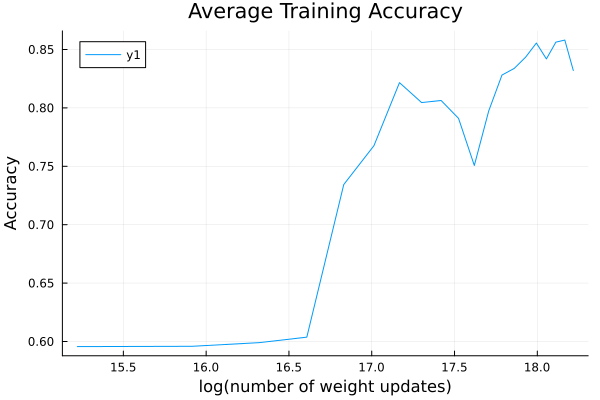

In [30]:
#Plotting Average Training Accuracy over 10 experiments
plot(ES_weight_updates, ES_train_accuracies, title="Average Training Accuracy")
xlabel!("log(number of weight updates)")
ylabel!("Accuracy")

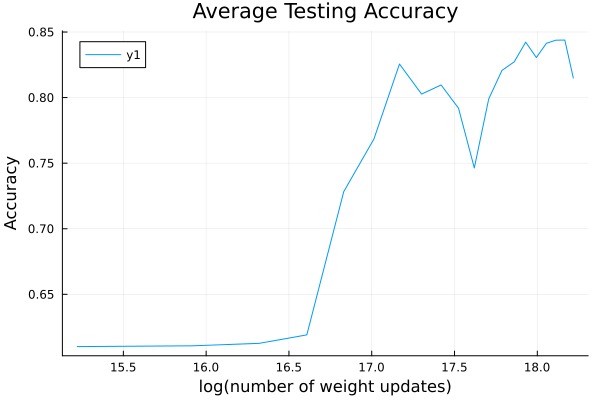

In [31]:
#Plotting Average Testing Accuracy over 10 experiments
plot(ES_weight_updates, ES_test_accuracies, title="Average Testing Accuracy")
xlabel!("log(number of weight updates)")
ylabel!("Accuracy")

In [35]:
#Generating Average Training Confusion Matrix
ES_train_conf_matrix = ES_train_conf_matrices[1]
for i in range(start=2, stop=size(ES_train_conf_matrices, 1), step=1)
    ES_train_conf_matrix[1, 1] = floor((ES_train_conf_matrix[1, 1] + ES_train_conf_matrices[i][1, 1]) / 2)
    ES_train_conf_matrix[1, 2] = floor((ES_train_conf_matrix[1, 2] + ES_train_conf_matrices[i][1, 2]) / 2)
    ES_train_conf_matrix[2, 1] = floor((ES_train_conf_matrix[2, 1] + ES_train_conf_matrices[i][2, 1]) / 2)
    ES_train_conf_matrix[2, 2] = floor((ES_train_conf_matrix[2, 2] + ES_train_conf_matrices[i][2, 2]) / 2)
end
println("Average Training Confusion Matrix")
println("\tP\t\tN")
println("T\t" * string(ES_train_conf_matrix[1, 1]) * "\t\t" * string(ES_train_conf_matrix[1, 2]))
println("F\t" * string(ES_train_conf_matrix[2, 1]) * "\t\t" * string(ES_train_conf_matrix[2, 2]))

Average Training Confusion Matrix
	P		N
T	350		83
F	59		354


In [36]:
#Generating Average Testing Confusion Matrix
ES_test_conf_matrix = ES_test_conf_matrices[1]
for i in range(start=2, stop=size(ES_test_conf_matrices, 1), step=1)
    ES_test_conf_matrix[1, 1] = floor((ES_test_conf_matrix[1, 1] + ES_test_conf_matrices[i][1, 1]) / 2)
    ES_test_conf_matrix[1, 2] = floor((ES_test_conf_matrix[1, 2] + ES_test_conf_matrices[i][1, 2]) / 2)
    ES_test_conf_matrix[2, 1] = floor((ES_test_conf_matrix[2, 1] + ES_test_conf_matrices[i][2, 1]) / 2)
    ES_test_conf_matrix[2, 2] = floor((ES_test_conf_matrix[2, 2] + ES_test_conf_matrices[i][2, 2]) / 2)
end
println("Average Testing Confusion Matrix")
println("\tP\t\tN")
println("T\t" * string(ES_test_conf_matrix[1, 1]) * "\t\t" * string(ES_test_conf_matrix[1, 2]))
println("F\t" * string(ES_test_conf_matrix[2, 1]) * "\t\t" * string(ES_test_conf_matrix[2, 2]))

Average Testing Confusion Matrix
	P		N
T	168		33
F	33		128
